<a href="https://colab.research.google.com/github/Nidhi-Mantri/MLR_Bike_Assignment/blob/main/MLR_Bike_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Linear Regression
## Bike Case Study
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

The company wants to know:
1.   Which variables are significant in predicting the demand for shared bikes.
2.   How well those variables describe the bike demands


In [74]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [76]:
# git clone
! git clone https://github.com/Nidhi-Mantri/MLR_Bike_Assignment.git

fatal: destination path 'MLR_Bike_Assignment' already exists and is not an empty directory.


# Step 1 - Reading and Understanding Data

In [77]:
# data dictionary
print("".join(open("/content/MLR_Bike_Assignment/data_dictionary.txt", "r").readlines()[:27]))

Dataset characteristics
day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	



In [78]:
bike_data = pd.read_csv("/content/MLR_Bike_Assignment/day.csv")
bike_data.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [79]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [80]:
bike_data.nunique()

instant       730
dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
dtype: int64

### Observations -
1. No null values in dataset, that means no need to impute data or drop any record.
2. Predictor is "cnt" column, we will ignore casual and registered columns as cnt is sum of both. Let's visualise this part and then drop these columns.
3. According to data dictionary, weathersit and season columns are not meaningful with current values.. need to convert them.
4. Since, "instant" column has all unique values, this is working just as an index column, we can ignore this.
5. as "instant" column, "dteday" column also has all unique values, and since we have mnth and yr column already available, we can drop this column.


# Step 2 - Data Preprocessing

### Let's remove below columns
1. instant column, as it is behaving as an index column.
2. dteday column, as mnth and yr are available.

In [81]:
bike_data = bike_data.drop(["instant", "dteday"], axis=1)

### Let's work on weathersit and season column
**weathersit and season column values are not proper as per data dict, we will correct mnth column for our convenience..**

These numeric values associated with the labels may indicate that there is some order to them -
which is actually not the case, as we can see in data dictionary above..
So, let's just fix it by converting them to categorical values.

**1. weathersit** :

		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
Instead of providing these big categorical values, we can give below concise and meaningful values -

		- 1: clear
		- 2: misty
		- 3: light_precipitation
		- 4: heavy_precipitation

**2. season** :- 1: spring, 2: summer, 3: fall, 4: winter

**3. mnth** :- 1 to 12 : jan to dec

**Note - we are converting them, so that we can have some meaningful columns after converting into dummy variables**

In [82]:
# week dict (in below cell) is derived after checking holiday, workingday and weekday columns..
# we can easily see that 1-5 are working days and 6 and 0 - non working days means weekend.
bike_data[["weekday", "holiday", "workingday"]].drop_duplicates()

,weekday,holiday,workingday
0,6,0,0
1,0,0,0
2,1,0,1
3,2,0,1
4,3,0,1
5,4,0,1
6,5,0,1
16,1,1,0
104,5,1,0
327,4,1,0


In [83]:
# weathersit column --> numerical to meaningful categorical values
weathersit_dict = {1:"clear", 2:"misty", 3:"light_precipitation", 4:"heavy_precipitation"}
bike_data["weathersit"] = bike_data["weathersit"].apply(lambda x : weathersit_dict[x])

# season column --> numerical to meaningful categorical values
season_dict = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
bike_data["season"] = bike_data["season"].apply(lambda x : season_dict[x])

# mnth column --> numerical to meaningful categorical values
month_dict = {1:"jan", 2:"feb", 3:"mar", 4:"apr", 5:"may", 6:"jun", 7:"jul", 8:"aug", 9:"sep", 10:"oct", 11:"nov", 12:"dec"}
bike_data["mnth"] = bike_data["mnth"].apply(lambda x : month_dict[x])

# weekday column --> numerical to meaningful categorical values
week_dict = {1:"mon", 2:"tue", 3:"wed", 4:"thu", 5:"fri", 6:"sat", 0:"sun"}
bike_data["weekday"] = bike_data["weekday"].apply(lambda x : week_dict[x])

In [84]:
# let's check the dataset again..
bike_data.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,0,jan,0,sat,0,misty,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,0,jan,0,sun,0,misty,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,0,jan,0,mon,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,0,jan,0,tue,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,0,jan,0,wed,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [85]:
# let's check the unique values in season column and corresponding counts
bike_data["season"].value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [86]:
# let's check the unique values in weather column and corresponding counts
bike_data["weathersit"].value_counts()

clear                  463
misty                  246
light_precipitation     21
Name: weathersit, dtype: int64

In [87]:
# let's check the unique values in month column and corresponding counts
bike_data["mnth"].value_counts()

jan    62
mar    62
may    62
jul    62
aug    62
oct    62
dec    62
apr    60
jun    60
sep    60
nov    60
feb    56
Name: mnth, dtype: int64

In [88]:
# let's check the unique values in weekday column and corresponding counts
bike_data["weekday"].value_counts()

sat    105
sun    105
mon    105
tue    104
thu    104
fri    104
wed    103
Name: weekday, dtype: int64

From above results, we can clearly see that
1. all four seasons are available in given dataset,
2. but only 3 (out of 4) weather situations are available and
3. all months data is there.
4. data for all weekdays is also present..

# Step 2 - Data Visualization
*   If there is some obvious multicollinearity going on, this is the first place to catch it.
*   Here's where we'll also identify if some predictors directly have a strong association with the outcome variable.

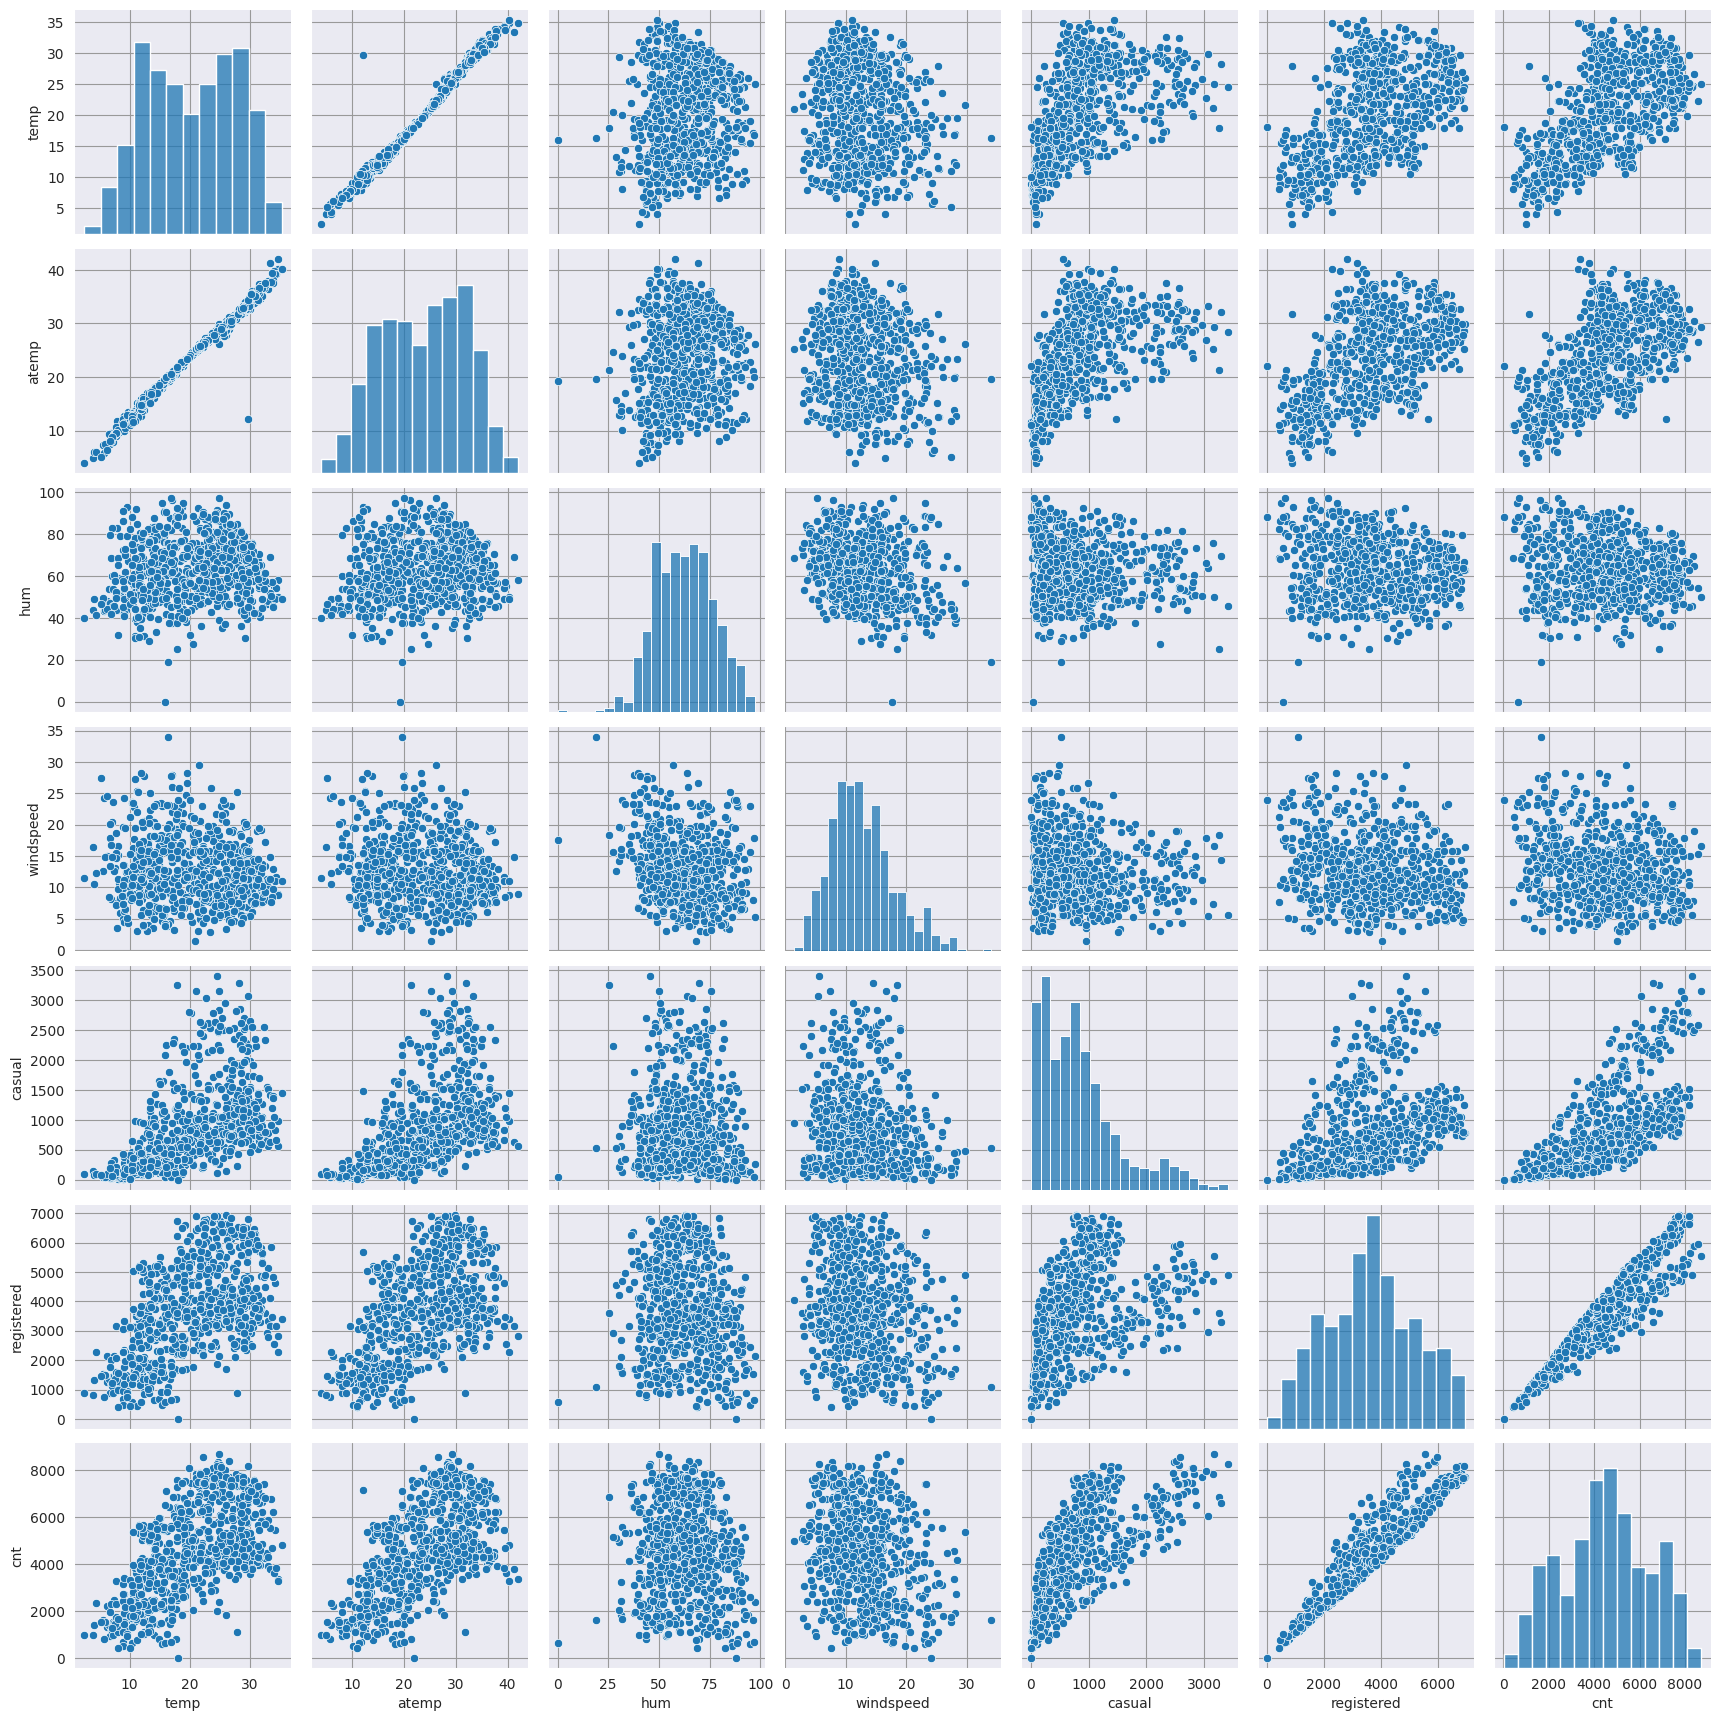

In [89]:
# let's see pairplot for all numerical variables of bike data
numerical_cols = ["temp", "atemp", "hum", "windspeed", "casual", "registered", "cnt"]
sns.pairplot(bike_data[numerical_cols])
plt.show()

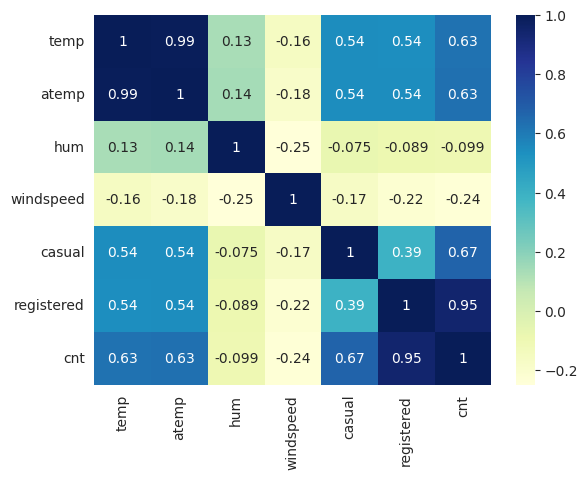

In [90]:
# let's visualize the actual correlation values between above numerical values
sns.heatmap(bike_data[numerical_cols].corr(), annot = True, cmap="YlGnBu")
plt.show()

From above plot we can see that -
1. temp and atemp are highly correlated, but we will see later based on p-values or vif, which one to drop.
2. cnt and registered are highly correlated.
3. cnt, registered and casual are positively correlated with temp and atemp columns

Note - about cnt, registered and casual columns, we have already see from data dictionary part that cnt = registered + casual, so we must use cnt as target variable. And since it is sum of both, we will remove registered and casual both.

In [91]:
bike_data = bike_data.drop(["registered", "casual"], axis=1)

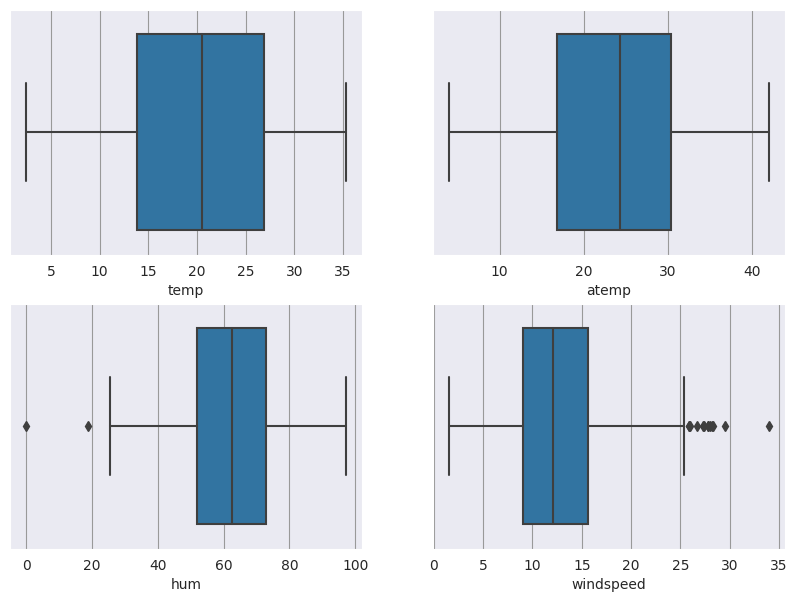

In [92]:
# Let's check distribution of above numerical columns
plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
sns.boxplot(x = 'temp', data = bike_data)
plt.subplot(2,2,2)
sns.boxplot(x = 'atemp', data = bike_data)
plt.subplot(2,2,3)
sns.boxplot(x = 'hum', data = bike_data)
plt.subplot(2,2,4)
sns.boxplot(x = 'windspeed', data = bike_data)
plt.show()

### Observations (numerical columns)
From above plots, we can clearly see that there are few outliers in humidity and windspeed columns. We know very well that regression line is very prone to outliers, a single outlier can easily deviate the regression line. It's better to remove these outliers from dataset

In [93]:
# let's try to find outliers in humidity (hum) column
bike_data["hum"].describe()

count    730.000000
mean      62.765175
std       14.237589
min        0.000000
25%       52.000000
50%       62.625000
75%       72.989575
max       97.250000
Name: hum, dtype: float64

In [94]:
bike_data[bike_data["hum"] < np.quantile(bike_data["hum"], 0.002)]
# np.quantile(bike_data["hum"], 0.002)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
49,spring,0,feb,0,sat,0,clear,16.365847,19.5702,18.7917,34.000021,1635
68,spring,0,mar,0,thu,1,light_precipitation,15.952731,19.2834,0.0000,17.545759,623


Observation -

    *   In above result, first record is having outlier with max value from windspeed
    *   second record is having 0 humidity on light precipitation day -- which is also wierd.
So that means at same time we are dealing with both columns.
Note - we are not dropping other outliers because range difference between outlier and start-boundary (in case of hum) and end-boundary (in case of windspeed)

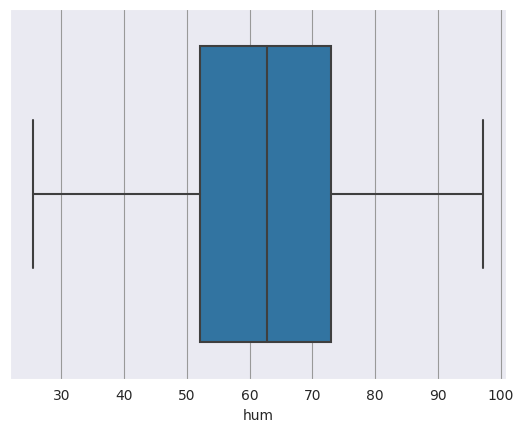

In [95]:
# SO, on light precipitation weather, humidity is 0... ??? it's wierd according to me. Also, there are only 2 outliers,
# let's drop both and see the distribution again.
bike_data = bike_data[bike_data["hum"] > np.quantile(bike_data["hum"], 0.002)]
sns.boxplot(x = 'hum', data = bike_data)
plt.show()

# let's see windspeed's distribution again - because we have dropped outliers from hum column
sns.boxplot(x = 'windspeed', data = bike_data)
plt.show()
# observation - it has dropped one outlier from windspeed..

In [96]:
bike_data[bike_data["windspeed"] > np.quantile(bike_data["windspeed"], 0.992)]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
44,spring,0,feb,0,mon,1,clear,17.015000,19.91750,37.5833,27.999836,1913
292,winter,0,oct,0,thu,1,clear,19.509153,23.32625,63.6250,28.292425,4195
382,spring,1,jan,0,wed,1,clear,12.436653,13.76270,44.3333,27.833743,3376
420,spring,1,feb,0,sat,0,clear,11.924153,12.78375,39.5833,28.250014,2732
431,spring,1,mar,0,thu,1,clear,21.627500,26.23020,56.7500,29.584721,5382
432,spring,1,mar,0,fri,1,misty,16.844153,19.85415,40.7083,27.791600,4569


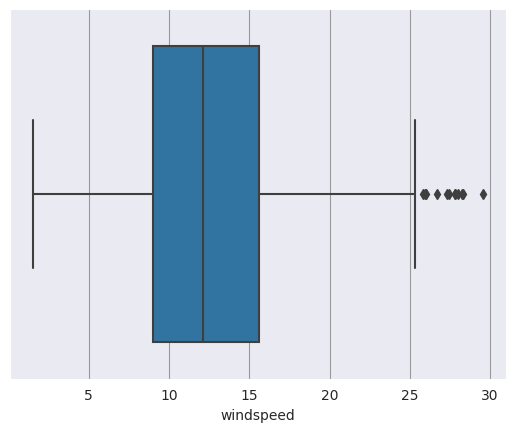

In [ ]:
# function to display values in various plots
def plot_annotation(splot):
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

<Figure size 640x480 with 0 Axes>

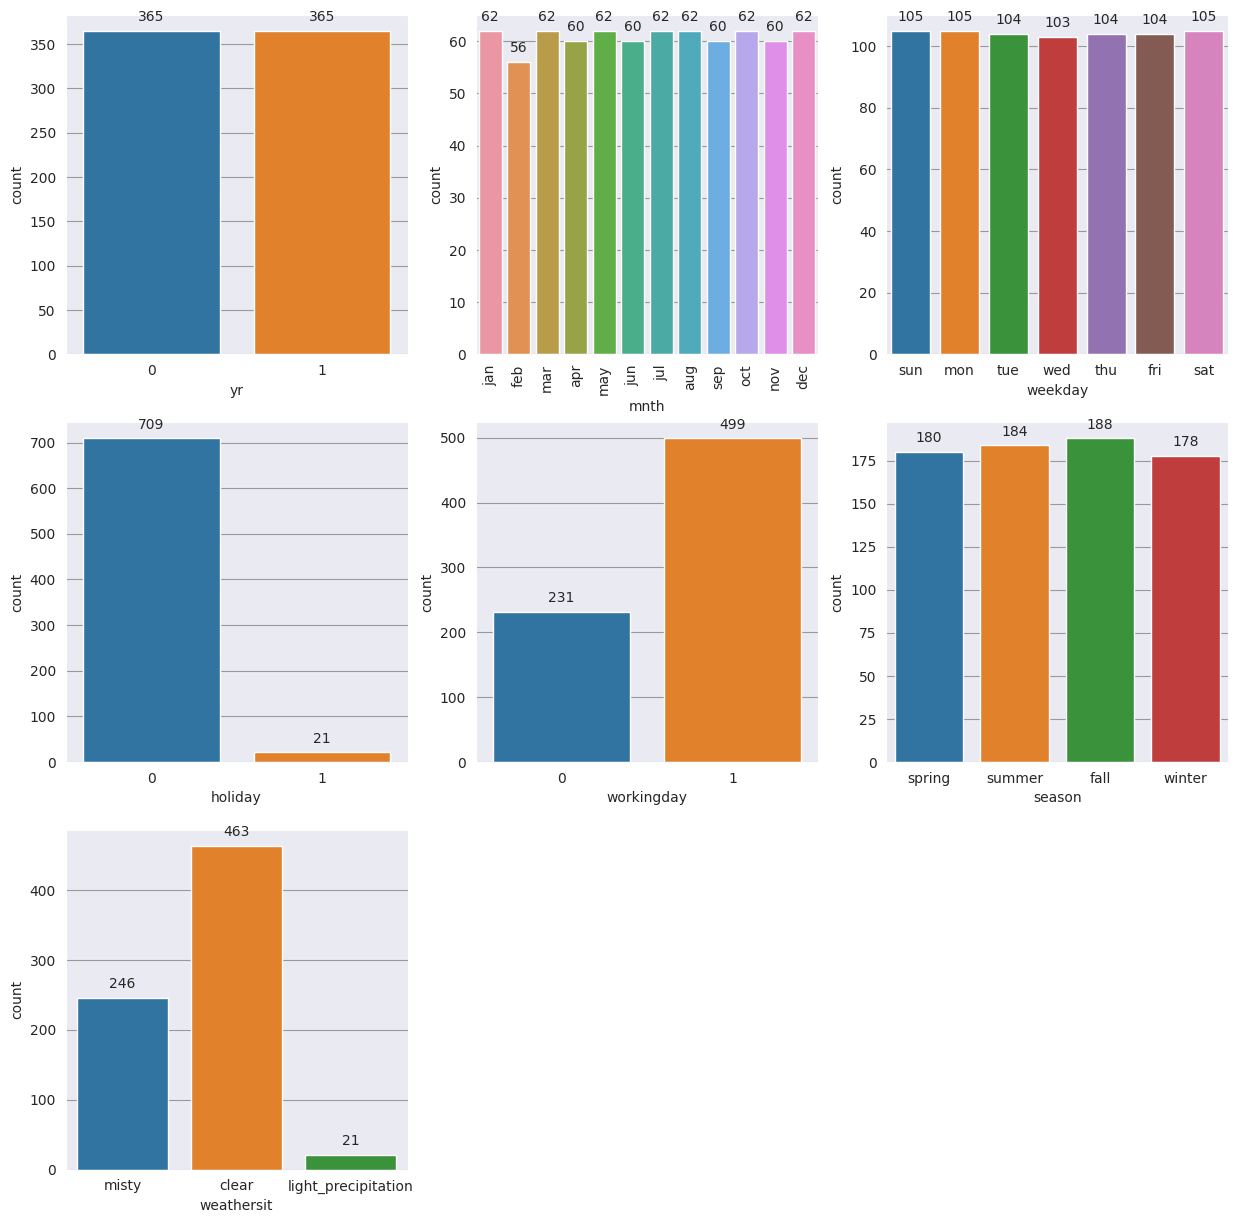

In [ ]:
# visualizing categorical variables
plt.subplots_adjust(bottom=0.5, hspace=2, wspace=0.4, top = 0.99)
# fig.suptitle('Comparison of Loan Amount, Funded Amount and Funded Amount by Investors', fontsize=18)
sns.set_style("darkgrid", {"grid.color": ".6"})

categorical_cols = ["yr", "mnth", "holiday", "weekday", "workingday", "season", "weathersit"]
plt.figure(figsize=(15, 15))
plt.subplot(3,3,1)
splot1 = sns.countplot(x='yr',  data = bike_data)
plot_annotation(splot1)
plt.subplot(3,3,2)
splot1 = sns.countplot(x = 'mnth', data = bike_data)
plot_annotation(splot1)
plt.xticks(rotation=90)
plt.subplot(3,3,3)
splot1 = sns.countplot(x = 'weekday', data = bike_data, order=["sun", "mon", "tue", "wed", "thu", "fri", "sat"])
plot_annotation(splot1)
plt.subplot(3,3,4)
splot1 = sns.countplot(x = 'holiday', data = bike_data)
plot_annotation(splot1)
plt.subplot(3,3,5)
splot1 = sns.countplot(x='workingday',  data = bike_data)
plot_annotation(splot1)
plt.subplot(3,3,6)
splot1 = sns.countplot(x = 'season', data = bike_data)
plot_annotation(splot1)
plt.subplot(3,3,7)
splot1 = sns.countplot(x = 'weathersit', data = bike_data)
plot_annotation(splot1)

plt.show()

### Observations (categorical columns) -
1. yr, mnth, weekday, holiday and workingday - these columns are actually calendar based.
    *   Since we have two years of data - 365*2 days = 730 (total records).
    *   feb has 28 days, hence 28*2 = 56 days in feb month.. similarly we can calculate in other months also.
    *   Similarly we can calculate number of all days.
    *   workingdays - monday to friday when there is no holiday and no weekend.
    *   holiday - as per calendar
2. season - all four seasons are equally distributed.
3. weathersit - data for heavy precipitation situation does not exist. But on most days, the weather is clear. On least number of days, there was light snow/rain.



**Now, let's create dummy variables for mnth, season, weekday and weathersit columns**

In [ ]:
month_data = pd.get_dummies(bike_data["mnth"])
month_data = month_data[["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]]
month_data.head(5)

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


From above results, we can see that if we drop any column or say "jan" column, even then remaining set of columns is enough because --

feb to dec - all zeros that means jan is 1

So, it implies we can drop any of above column (whatever will be the first)

**Note - same logic we will apply to season, weathersit and weekday column**

In [ ]:
# mnth column
month_data = pd.get_dummies(bike_data["mnth"], drop_first=True)
print("month data -->")
print(month_data.head(3), "\n")
# it has dropped "apr" column (as per alphabetical order)

# weekday column
weekday_data = pd.get_dummies(bike_data["weekday"], drop_first=True)
print("weekday data -->")
print(weekday_data.head(3), "\n")
# it has dropped "fri" day

# season column
season_data = pd.get_dummies(bike_data["season"], drop_first=True)
print("season data -->")
print(season_data.head(3), "\n")
# it has dropped "fall" season

# weathersit column
weathersit_data = pd.get_dummies(bike_data["weathersit"], drop_first=True)
print("weathersit data -->")
print(weathersit_data.head(3))
# it has dropped "clear" weather situation

month data -->
   aug  dec  feb  jan  jul  jun  mar  may  nov  oct  sep
0    0    0    0    1    0    0    0    0    0    0    0
1    0    0    0    1    0    0    0    0    0    0    0
2    0    0    0    1    0    0    0    0    0    0    0 

weekday data -->
   mon  sat  sun  thu  tue  wed
0    0    1    0    0    0    0
1    0    0    1    0    0    0
2    1    0    0    0    0    0 

season data -->
   spring  summer  winter
0       1       0       0
1       1       0       0
2       1       0       0 

weathersit data -->
   light_precipitation  misty
0                    0      1
1                    0      1
2                    0      0


In [ ]:
# let's concatenate all columns to bike dataset
bike_data = pd.concat([bike_data, month_data, weekday_data, season_data, weathersit_data], axis = 1)
bike_data.drop(["mnth", "weekday", "season", "weathersit"], axis=1)

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,sat,sun,thu,tue,wed,spring,summer,winter,light_precipitation,misty
0,0,0,0,14.110847,18.18125,80.5833,10.749882,331,654,985,...,1,0,0,0,0,1,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,131,670,801,...,0,1,0,0,0,1,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,...,0,0,0,1,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,0,1,10.420847,11.33210,65.2917,23.458911,247,1867,2114,...,0,0,1,0,0,1,0,0,0,1
726,1,0,1,10.386653,12.75230,59.0000,10.416557,644,2451,3095,...,0,0,0,0,0,1,0,0,0,1
727,1,0,0,10.386653,12.12000,75.2917,8.333661,159,1182,1341,...,1,0,0,0,0,1,0,0,0,1
728,1,0,0,10.489153,11.58500,48.3333,23.500518,364,1432,1796,...,0,1,0,0,0,1,0,0,0,0


In [ ]:
bike_data.describe()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,6.526027,0.028767,2.997260,0.683562,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,0.500343,3.450215,0.167266,2.006161,0.465405,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,0.000000,1.000000,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,0.000000,4.000000,0.000000,1.000000,0.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,0.500000,7.000000,0.000000,3.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,1.000000,10.000000,0.000000,5.000000,1.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,1.000000,12.000000,1.000000,6.000000,1.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000
